<a href="https://colab.research.google.com/github/jfrank94/SParCS/blob/master/Model_Experiments_Mount_Sinai_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

In [2]:
cd /content/drive/My Drive/MyDrive/SParCS Project/

/content/drive/My Drive/MyDrive/SParCS Project


In [0]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns

In [0]:
import os
path_to_data = 'MSSM_COVID_FINAL/'
files = []
for file in os.listdir(path_to_data):
  if file.endswith('.txt'):
    files.append(file)

patient_df = pd.read_csv(path_to_data + files[0], sep="\t", 
                        error_bad_lines=False, encoding='latin1')

In [6]:
"There are {} features in the patient dataset.".format(patient_df.shape[1])

'There are 73 features in the patient dataset.'

In [0]:
patient_df = patient_df.fillna(0)

In [0]:
patient_df_modified = patient_df.drop(columns=['ZIPCODE', 'MASKED_MRN', 'MASKED_ENCOUNTER_EPIC_CSN', 'FACILITY', 'ENC_ACUITY',
                                               'TOCILIZUMAB', 'DATE_OF_FIRST_TOCILIZUMAB', 'DECEASED_INDICATOR', 'TOCILIZUMAB',
                                                'DATE_OF_FIRST_TOCILIZUMAB', 'REMDESIVIR', 'DATE_OF_FIRST_REMDESIVIR',
                                               'SARILUMAB', 'DATE_OF_FIRST_SARILUMAB', 'HYDROXYCHLOROQUINE',
                                                'DATE_OF_FIRST_HYDROXYCHLOROQUINE', 'ANAKINRA',
                                                'DATE_OF_FIRST_ANAKINRA', 'AZITHROMYCIN', 'DATE_OF_FIRST_AZITHROMYCIN', 'ADMITTED', 'ICU'])


In [9]:
#modifying the object values into categorical data 
cols_str = []
for col in patient_df_modified.columns: 
  if patient_df_modified[col].dtype == object or patient_df_modified[col].dtype == bool:
    cols_str.append(col)
  #print(patient_df_modified[col].dtype == bool)

for col in cols_str: 
  patient_df_modified[col] = pd.Categorical(patient_df_modified[col]).codes
print(cols_str)

['SEX', 'COVID_POS', 'CANCER_DIAGNOSIS_DESCRIPTION', 'RACE_SIMPLE', 'SMOKING_SIMPLE', 'COPD_ASTHMA']


In [0]:
target = patient_df_modified['COVID_POS']

In [0]:
!pip install eli5

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from  sklearn.base import BaseEstimator

import eli5
from eli5.sklearn import PermutationImportance
from IPython.core.display import display, HTML

from xgboost import XGBClassifier
from scipy import sparse

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

class TrainClassifier(BaseEstimator):
    
    def __init__(self, classifier=XGBClassifier(tree_hist='gpu_hist')):
        self.classifier = classifier 

    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 

    #1st method of feature extraction 
    def permutationImportances(self, model, dataset, X, y=None, display=False):
      model = model.fit(X, y)
      perm = PermutationImportance(model, random_state=42).fit(X, y)
      perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=X.columns.tolist()))
      if display: 
        display(eli5.show_weights(perm, feature_names=X.columns.tolist(), top=50))
      perm_df_filtered = perm_df[perm_df['weight'] >= 0]
      dataset_filtered = dataset[list(perm_df_filtered['feature'])]
      return dataset_filtered

    #2nd method of feature extraction 
    def bioMarkerFilter(self, dataset):
      biomarkers = ['SMOKING_SIMPLE', 'COPD_ASTHMA', 'DIABETES', 'CHRONIC_KIDNEY_DISEASE', 'HIV_FLAG',
              'CANCER_FLAG', 'BMI', 'HTN', 'TEMPERATURE', 'HTN', 'HEART_RATE', 'RESPIRATORY_RATE',
              'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT']
      biomarkers = biomarkers + [col for col in dataset.columns if col.endswith('_INITIAL')]
      dataset_modified_biomarkers = dataset[biomarkers]
      return dataset_modified_biomarkers 
      
    def predict(self, X, y=None):
        self.classifier.predict(X)

    def score(self, X, y=None):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        accuracy = accuracy_score(y_important_test, predictions)
        return ("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    def displayPredictionMatrix(self, X_test, y_test):
      unique_labels = [0, 1]
      testing_predictions = self.classifier.predict(X_test)
      seed = np.random.seed(0)
      matrix = confusion_matrix(y_test, testing_predictions, labels=unique_labels)
      sns.heatmap(matrix, annot=True, xticklabels=unique_labels, yticklabels=unique_labels)
      plt.ylabel('Actual/True Label')
      plt.xlabel('Predicted Label')
      plt.title('Confusion Matrix for Predicted Labeling')

In [0]:
import pickle

patient_df_modified_features = patient_df_modified.columns
patient_df_modified_features = [feature for feature in patient_df_modified_features if feature != "COVID_POS"]
target = patient_df_modified['COVID_POS']

X_train, X_test, y_train, y_test = train_test_split(patient_df_modified[patient_df_modified_features], 
                                                        target, test_size=0.3, random_state=np.random.seed(0))
    
pipe = Pipeline([('preprocessing', MinMaxScaler()),  
                 ('classifier', RandomForestClassifier())])
               
params =  {'classifier': [RandomForestClassifier()], 
         'preprocessing': [MinMaxScaler(feature_range=(0, 1))],
         'classifier__max_features': ['auto', 'sqrt'],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__n_estimators': [int(x) for x in np.linspace(start=200, stop=300, num=10)], 
         'classifier__max_depth': [int(x) for x in np.linspace(start=10, stop=50, num=10)],
         'classifier__bootstrap': [True, False]}

rscv = RandomizedSearchCV(pipe, params, n_iter=100, verbose=2, cv=5, random_state=np.random.seed(0), n_jobs=-1)
rscv.fit(X_train, y_train)
random_forest_best = rscv.best_params_['classifier']
filename = 'random_forest_best.sav'
rfcb_saved = pickle.dump(random_forest_best, open(filename, 'wb'))
rfcb_loaded = pickle.load(open(filename, 'rb'))
rfcb_model = rfcb_loaded.fit(X_train, y_train)

In [53]:
tr = TrainClassifier()
permutation_dataset = tr.permutationImportances(rfcb_model, patient_df_modified, X_test, y_test)

X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(permutation_dataset, 
                                                                                            target, test_size=0.3, random_state=42)
tr.fit(X_important_train, y_important_train)
tr.score(X_important_test)

'Accuracy: 52.78%'

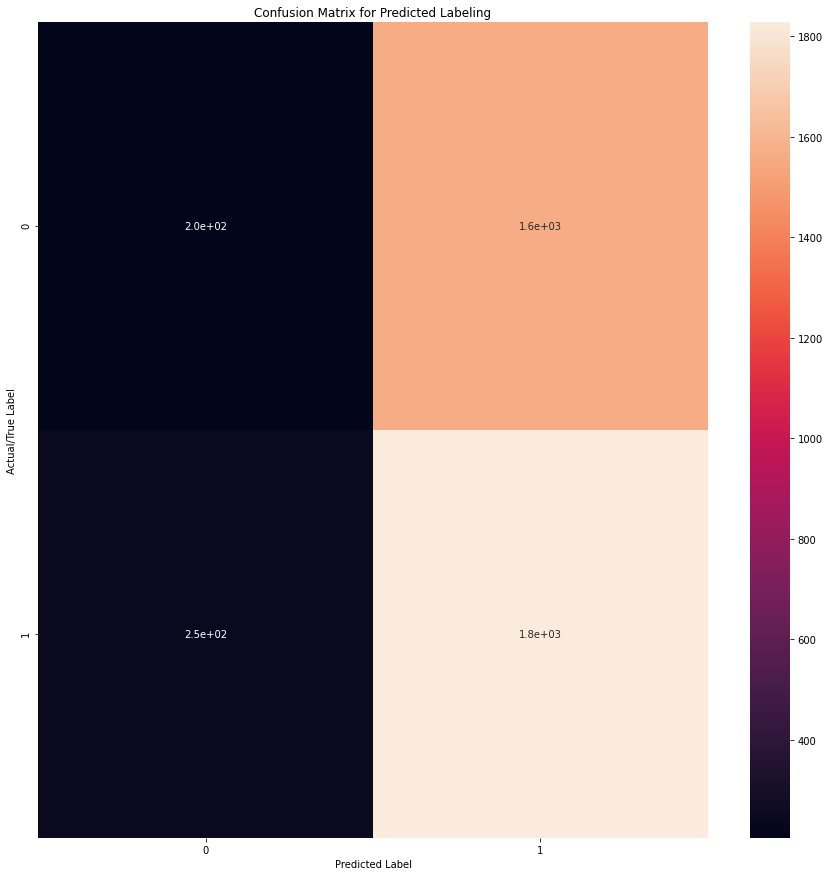

In [54]:
plt.figure(figsize=(15, 15))
tr.displayPredictionMatrix(X_important_test, y_important_test)

In [31]:
biomarker_dataset = tr.bioMarkerFilter(patient_df_modified)

X_train, X_test, y_train, y_test = train_test_split(patient_df_modified[patient_df_modified_features], 
                                                        target, test_size=0.3, random_state=np.random.seed(0))

tr.fit(X_train, y_train)
tr.score(X_test)

'Accuracy: 52.70%'